# Time series 

Importation librairies

In [1]:
!pip install pandas matplotlib scikit-learn statsmodels prophet


  Obtaining dependency information for prophet from https://files.pythonhosted.org/packages/c7/ef/925617d36c08e0bbdf4347a9b38974ce7ab8fdb5d1a5cf0e3f3c65ea43da/prophet-1.1.7-py3-none-win_amd64.whl.metadata
  Obtaining dependency information for cmdstanpy>=1.0.4 from https://files.pythonhosted.org/packages/2a/80/04b3989f055e555737b3b6944f02112e90cfc4f2e53c763771dded22e684/cmdstanpy-1.2.5-py3-none-any.whl.metadata
  Obtaining dependency information for holidays<1,>=0.25 from https://files.pythonhosted.org/packages/65/9c/01da17421bd6a0aa230839b8313fa1615c81555f94954350fca4f4b7f129/holidays-0.73-py3-none-any.whl.metadata
  Obtaining dependency information for importlib_resources from https://files.pythonhosted.org/packages/a4/ed/1f1afb2e9e7f38a545d628f864d562a5ae64fe6f7a10e28ffb9b185b4e89/importlib_resources-6.5.2-py3-none-any.whl.metadata
  Obtaining dependency information for stanio<2.0.0,>=0.4.0 from https://files.pythonhosted.org/packages/56/87/37a80e4d5bd453c33262d8fb618b6840fd98d24ed

In [82]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from math import sqrt

from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from prophet import Prophet

Codes

In [10]:
df = pd.read_csv("weather.csv")
df['date'] = pd.to_datetime(df['date'], errors='coerce')

In [14]:
df

,id,date,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,region
0,0,2000-01-01,1025.3,4.1,3.2,2.4,2.4,94.3,95,0.0,270,2.6,1.2,90
1,1,2000-01-02,1010.7,8.8,5.3,2.4,-2.5,62.3,65,3.5,290,11.5,1.1,90
2,2,2000-01-03,1016.3,6.0,1.8,-2.7,-15.3,29.4,20,8.4,290,9.5,0.0,90
3,3,2000-01-04,1022.7,5.5,1.0,-2.7,-11.7,40.5,28,5.6,290,3.3,0.0,90
4,4,2000-01-05,1020.3,1.7,0.9,-0.1,-1.3,87.0,100,0.0,290,2.7,10.4,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
774310,774310,2024-08-08,999.5,34.3,29.3,25.8,24.8,78.0,55,8.6,270,2.9,0.0,295
774311,774311,2024-08-09,999.2,34.2,28.3,25.2,22.9,74.1,26,11.5,250,3.2,0.0,295
774312,774312,2024-08-10,999.1,32.6,27.7,24.6,23.7,79.9,24,10.2,250,2.6,0.0,295
774313,774313,2024-08-11,998.8,32.7,28.0,24.2,23.4,77.6,31,10.4,270,2.7,0.0,295


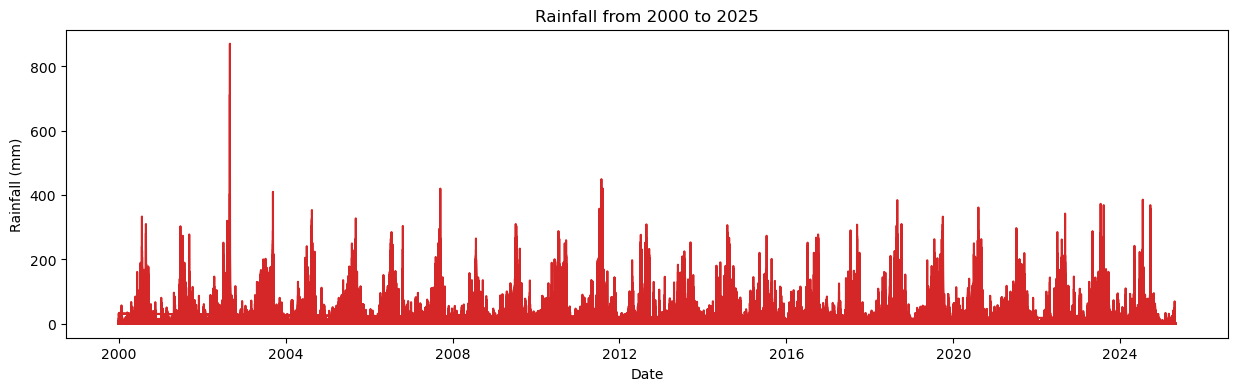

In [157]:
#Visualisation
def plot_df(df, x, y, title="", xlabel='Date', ylabel='Rainfall (mm)', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(df, x=df['date'], y=df['rainfall'], title='Rainfall from 2000 to 2025')


## Some analysis

Average total of raining day by year : 108.4 jours
          date     id  pressure  maxtemp  temparature  mintemp  dewpoint  \
0   2023-01-01  98116    1019.8      3.8         -0.2     -4.3      -8.7   
1   2023-01-02  98117    1021.0     -0.4         -4.5     -7.4     -14.6   
2   2023-01-03  98118    1019.5      0.6         -5.0     -9.0     -14.6   
3   2023-01-04  98119    1019.5      3.3         -1.8     -5.7     -10.7   
4   2023-01-05  98120    1019.6      3.6         -1.6     -5.6      -8.9   
..         ...    ...       ...      ...          ...      ...       ...   
341 2023-12-08  98457    1002.5     16.8         11.2      5.1       6.5   
342 2023-12-09  98458    1006.8     16.2         13.7     11.7      10.8   
343 2023-12-10  98459    1012.0     15.5         11.4      6.7       5.3   
344 2023-12-11  98460    1006.7     12.3          8.9      5.0       6.1   
345 2023-12-12  98461    1010.5      9.3          5.4      3.5       1.3   

     humidity  cloud  sunshine  wind

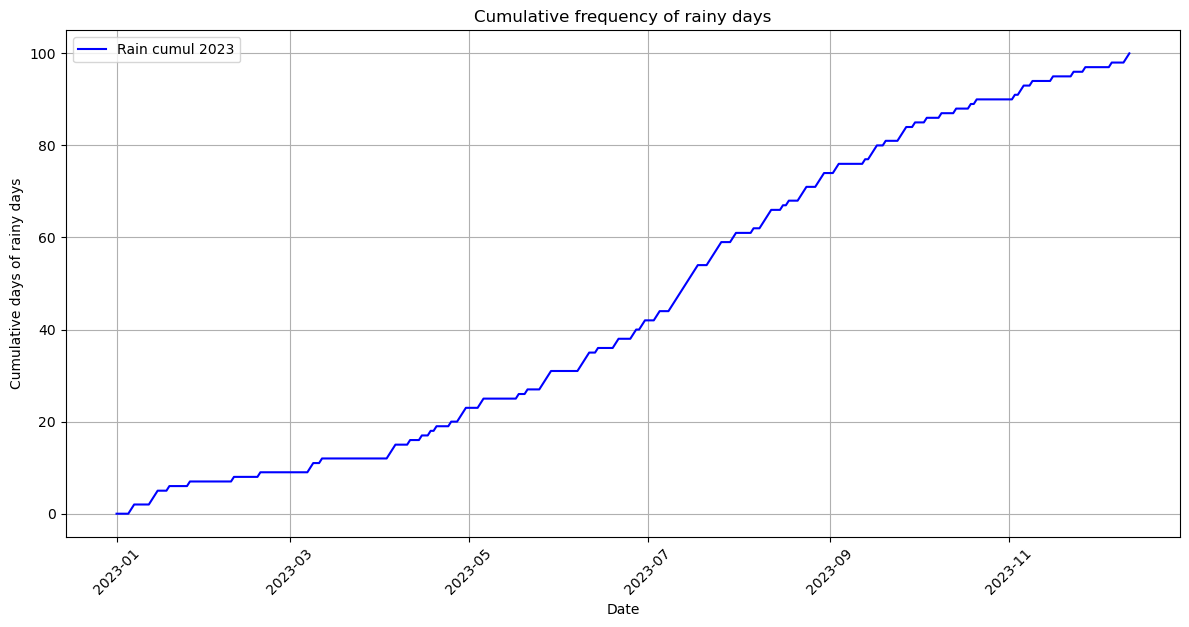

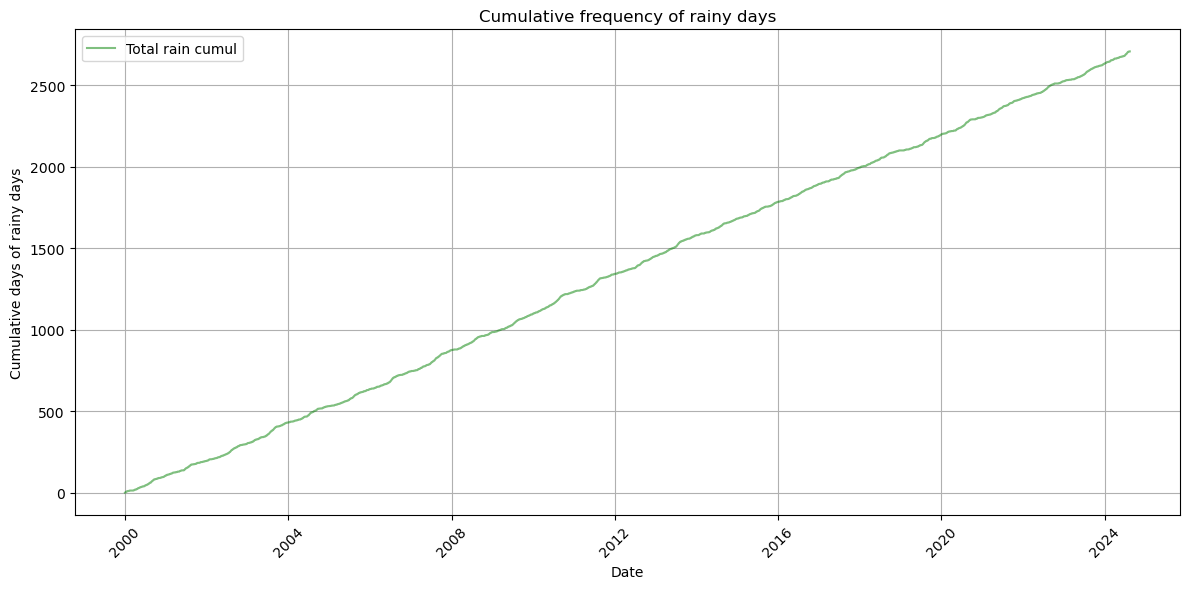


Probability of raining after 6 days in a row : 67.21%


In [33]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

df_analysis = df[df['region'] == 108].copy()
df_analysis['year'] = df_analysis['date'].dt.year
df_analysis['rain'] = (df_analysis['rainfall'] > 0).astype(int)

rain_days_per_year = df_analysis.groupby('year')['rain'].sum()
mean_rain_days = rain_days_per_year.mean()
print(f"Average total of raining day by year : {mean_rain_days:.1f} jours")


df_2023 = df_analysis.copy()
df_2023.set_index('date',inplace=True)
df_2023 = df_2023["2023-01-01":"2023-12-12"]
df_2023.reset_index(inplace=True)

df_2023['cumulative_rain'] = df_2023['rain'].cumsum()
print(df_2023)
df_analysis['cumulative_rain'] = df_analysis['rain'].cumsum()

plt.figure(figsize=(12, 6))
plt.plot(df_2023['date'], df_2023['cumulative_rain'], label='Rain cumul 2023', color='blue')
plt.title("Cumulative frequency of rainy days")
plt.ylabel("Cumulative days of rainy days")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

plt.figure(figsize=(12, 6))
plt.plot(df_analysis['date'], df_analysis['cumulative_rain'], label='Total rain cumul', color='green', alpha=0.5)
plt.xlabel("Date")
plt.title("Cumulative frequency of rainy days")
plt.ylabel("Cumulative days of rainy days")
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

df_analysis['rain_6days'] = df_analysis['rain'].rolling(6).apply(lambda x: all(x), raw=True).shift(1)

condition = df_analysis['rain_6days'] == 1
pluie_apres_6 = df_analysis[condition]['rain']

if not pluie_apres_6.empty:
    p_pluie_apres_6 = pluie_apres_6.mean()
    print(f"\nProbability of raining after 6 days in a row : {p_pluie_apres_6:.2%}")
else:
    print("\nNo series detected.")


          date     id  pressure  maxtemp  temparature  mintemp  dewpoint  \
0   2024-01-01  98481    1016.1      7.3          3.3     -0.3       0.5   
1   2024-01-02  98482    1011.4      4.3          2.9      2.2      -1.6   
2   2024-01-03  98483    1008.6      4.0          1.8     -1.1      -1.2   
3   2024-01-04  98484    1010.9      4.7          1.4     -3.3      -2.7   
4   2024-01-05  98485    1009.1      9.1          5.0      1.4       1.2   
..         ...    ...       ...      ...          ...      ...       ...   
220 2024-08-08  98701     994.7     31.6         28.5     26.9      24.1   
221 2024-08-09  98702     994.2     33.6         29.3     25.6      24.0   
222 2024-08-10  98703     993.0     33.6         30.0     26.4      23.8   
223 2024-08-11  98704     992.5     34.4         30.8     27.8      24.0   
224 2024-08-12  98705     994.5     34.1         31.1     28.2      24.9   

     humidity  cloud  sunshine  winddirection  windspeed  rainfall  region  \
0        

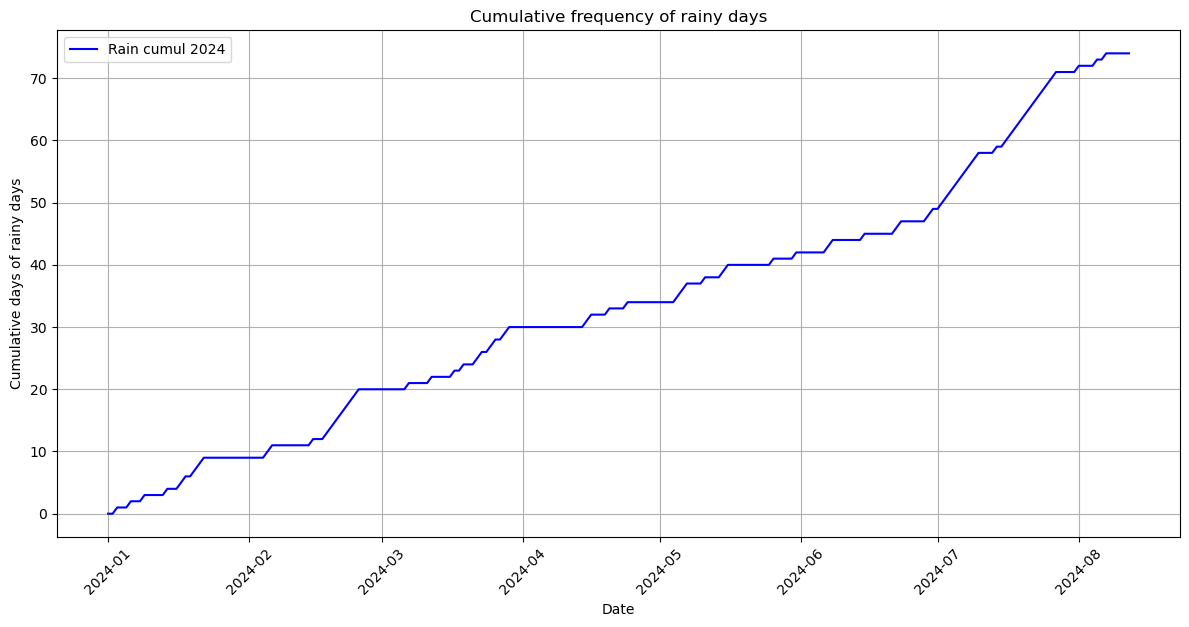

In [37]:
import pandas as pd

df_2024 = df_analysis.copy()
df_2024.set_index('date',inplace=True)
df_2024 = df_2024["2024-01-01"::]
df_2024.reset_index(inplace=True)

df_2024['cumulative_rain'] = df_2024['rain'].cumsum()
print(df_2024)

plt.figure(figsize=(12, 6))
plt.plot(df_2024['date'], df_2024['cumulative_rain'], label='Rain cumul 2024', color='blue')
plt.title("Cumulative frequency of rainy days")
plt.ylabel("Cumulative days of rainy days")
plt.xlabel("Date")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.xticks(rotation=45)

plt.show()

In [158]:
#Group by region, and for the train-test part, only keep the ones for 257 for example
df_257 = df[df['region'] == 257].copy()
#and removing the duplicates
df_257 = df_257.sort_values('date').reset_index(drop=True)
df_257

,id,date,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,region
0,582469,2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,257
1,582470,2009-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,257
2,582471,2009-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,257
3,582472,2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,257
4,582473,2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0,0.0,0,0.0,0.0,257
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5958,588427,2025-04-26,1017.1,24.6,15.0,7.1,-0.1,39.0,5,10.9,230,5.5,0.0,257
5959,588428,2025-04-27,1013.5,25.4,18.1,10.7,4.8,44.9,71,7.8,200,5.7,0.0,257
5960,588429,2025-04-28,1006.6,24.4,19.2,14.0,6.8,48.4,38,8.5,200,5.6,0.0,257
5961,588430,2025-04-29,1012.2,19.9,14.5,8.8,5.5,57.6,0,10.9,230,6.2,0.0,257


In [159]:
#To use only the last year for the train
df.set_index('date', inplace=True)

df['2022-01-01':'2022-12-31']
#Might be better to use full dataset (2000 to 2024?)

,id,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,region
date,,,,,,,,,,,,,
2022-01-01,8036,1025.8,2.1,-3.3,-9.2,-15.2,40.8,18,9.0,270,2.6,0.0,90
2022-01-02,8037,1020.4,5.9,2.2,-2.4,-11.7,37.8,19,8.1,290,5.4,0.0,90
2022-01-03,8038,1019.9,3.0,0.6,-3.0,-14.4,33.9,25,8.0,290,4.7,0.0,90
2022-01-04,8039,1023.6,1.8,-1.2,-4.2,-12.4,43.4,8,8.9,290,5.6,0.0,90
2022-01-05,8040,1025.9,1.9,-1.5,-4.9,-8.3,60.1,44,7.2,290,3.7,0.0,90
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-12-27,773720,1021.7,7.7,1.6,-2.1,-6.6,55.1,15,8.0,250,2.3,0.0,295
2022-12-28,773721,1023.2,7.4,2.0,-1.5,-6.0,55.8,45,7.1,250,5.0,0.0,295
2022-12-29,773722,1026.0,6.4,1.3,-2.8,-6.6,56.4,33,8.0,250,3.1,0.0,295


In [160]:
df_arima = df_257[['date', 'rainfall']].dropna()
df_arima

,date,rainfall
0,2009-01-01,0.0
1,2009-01-02,0.0
2,2009-01-03,0.0
3,2009-01-04,0.0
4,2009-01-05,0.0
...,...,...
5958,2025-04-26,0.0
5959,2025-04-27,0.0
5960,2025-04-28,0.0
5961,2025-04-29,0.0


ARIMA

In [161]:
df_arima['rainfall_log'] = np.log1p(df_arima['rainfall']) 
df_arima = df_arima.set_index('date').asfreq('D').fillna(0)
train = df_arima[:'2022']
val = df_arima['2023-01':'2023-09']
test = df_arima['2023-10':]
test

,rainfall,rainfall_log
date,,
2023-10-01,0.0,0.000000
2023-10-02,0.0,0.000000
2023-10-03,1.4,0.875469
2023-10-04,0.0,0.000000
2023-10-05,0.0,0.000000
...,...,...
2025-04-26,0.0,0.000000
2025-04-27,0.0,0.000000
2025-04-28,0.0,0.000000



ARIMA (predict rainfall based on previous value of rainfall)
MSE on validation : 611.2728
RMSE on validation : 24.7239
MAE on validation : 7.3993


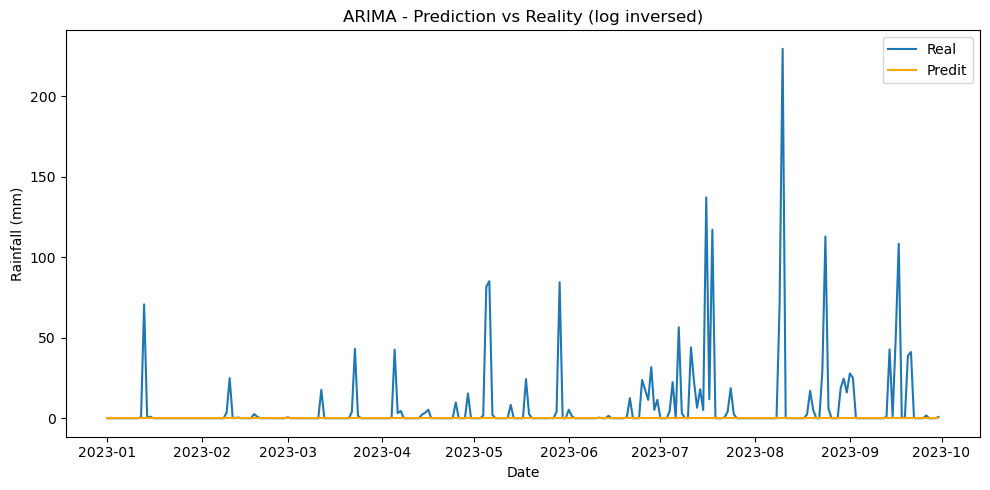

In [146]:
print("\nARIMA (predict rainfall based on previous value of rainfall)")
arima_model = ARIMA(train['rainfall_log'], order=(5, 1, 0))
arima_result = arima_model.fit()

arima_pred_log = arima_result.predict(start=val.index[0], end=val.index[-1])
arima_pred = np.expm1(arima_pred_log)

true_values = val['rainfall']
rmse_arima = np.sqrt(mean_squared_error(true_values, arima_pred))
mae_arima = mean_absolute_error(true_values, arima_pred)
mse_arima = mean_squared_error(true_values, arima_pred)
print(f"MSE on validation : {mse_arima:.4f}")
print(f"RMSE on validation : {rmse_arima:.4f}")
print(f"MAE on validation : {mae_arima:.4f}")

plt.figure(figsize=(10, 5))
plt.plot(true_values.index, true_values, label="Real")
plt.plot(arima_pred.index, arima_pred, label="Predit", color="orange")
plt.title("ARIMA - Prediction vs Reality (log inversed)")
plt.xlabel("Date")
plt.ylabel("Rainfall (mm)")
plt.legend()
plt.tight_layout()
plt.show()


SARIMAX 

In [147]:
df_sarimax = df_257.dropna()
df_sarimax = df_sarimax.sort_values(by='date') 
df_sarimax = df_sarimax.groupby('date').sum().reset_index()
df_sarimax = df_sarimax.set_index('date').asfreq('D').fillna(0)
df_sarimax = df_sarimax.fillna(method='ffill').fillna(method='bfill')
df_sarimax

,id,pressure,maxtemp,temparature,mintemp,dewpoint,humidity,cloud,sunshine,winddirection,windspeed,rainfall,region
date,,,,,,,,,,,,,
2009-01-01,582469.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0
2009-01-02,582470.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0
2009-01-03,582471.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0
2009-01-04,582472.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0
2009-01-05,582473.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,257.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-04-26,588427.0,1017.1,24.6,15.0,7.1,-0.1,39.0,5.0,10.9,230.0,5.5,0.0,257.0
2025-04-27,588428.0,1013.5,25.4,18.1,10.7,4.8,44.9,71.0,7.8,200.0,5.7,0.0,257.0
2025-04-28,588429.0,1006.6,24.4,19.2,14.0,6.8,48.4,38.0,8.5,200.0,5.6,0.0,257.0



SARIMAX
SARIMAX - MSE on validation : 729.6255
RMSE on validation : 27.0116
MAE on validation : 16.1801


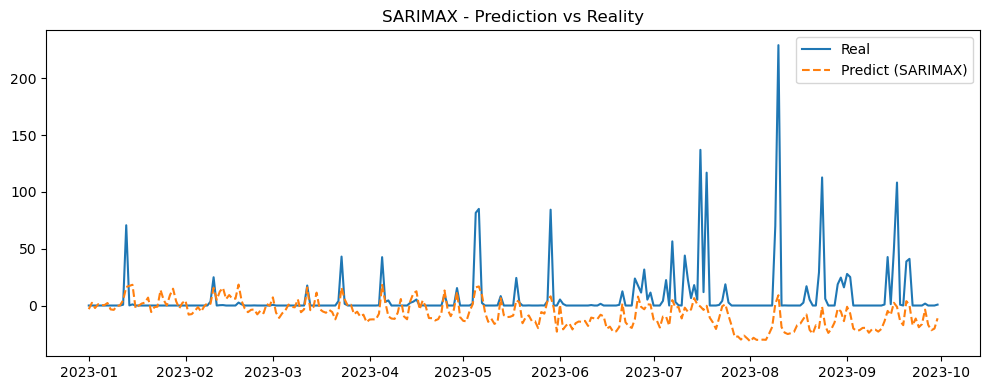

In [148]:
exog = df_sarimax.drop(columns='rainfall')

train_y = df_sarimax['rainfall'][:'2022']
val_y = df_sarimax['rainfall']['2023-01':'2023-09']
train_X = exog[:'2022']
val_X = exog['2023-01':'2023-09']

print("\nSARIMAX")
sarimax_model = SARIMAX(train_y, exog=train_X,order=(1, 1, 1))
sarimax_result = sarimax_model.fit(disp=False)

sarimax_pred = sarimax_result.predict(start=val_y.index[0], end=val_y.index[-1], exog=val_X)

rmse_sarimax = np.sqrt(mean_squared_error(val_y, sarimax_pred))
mae_sarimax = mean_absolute_error(val_y, sarimax_pred)
mse_sarimax = mean_squared_error(val_y, sarimax_pred)
print(f"MSE on validation : {mse_sarimax:.4f}")
print(f"RMSE on validation : {rmse_sarimax:.4f}")
print(f"MAE on validation : {mae_sarimax:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(val_y.index, val_y, label='Real')
plt.plot(val_y.index, sarimax_pred, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()


Try to keep only the interesting variables : 

In [149]:
corr = df_sarimax.corr()
print(corr['rainfall'].sort_values(ascending=False))
filtered_names = corr['rainfall'][corr['rainfall'] > 0.1].index.tolist()
print(filtered_names)
df_sarimax_bis = df_sarimax[filtered_names]
df_sarimax_bis

rainfall         1.000000
humidity         0.333763
windspeed        0.221788
dewpoint         0.221127
mintemp          0.190735
temparature      0.145981
cloud            0.145903
maxtemp          0.082438
id               0.005087
region           0.003279
pressure        -0.029209
winddirection   -0.076691
sunshine        -0.343755
Name: rainfall, dtype: float64
['temparature', 'mintemp', 'dewpoint', 'humidity', 'cloud', 'windspeed', 'rainfall']


,temparature,mintemp,dewpoint,humidity,cloud,windspeed,rainfall
date,,,,,,,
2009-01-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2009-01-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...
2025-04-26,15.0,7.1,-0.1,39.0,5.0,5.5,0.0
2025-04-27,18.1,10.7,4.8,44.9,71.0,5.7,0.0
2025-04-28,19.2,14.0,6.8,48.4,38.0,5.6,0.0



SARIMAX


C:\Users\hindi\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


SARIMAX - MSE on validation : 435.3362
RMSE on validation : 20.8647
MAE on validation : 8.8306


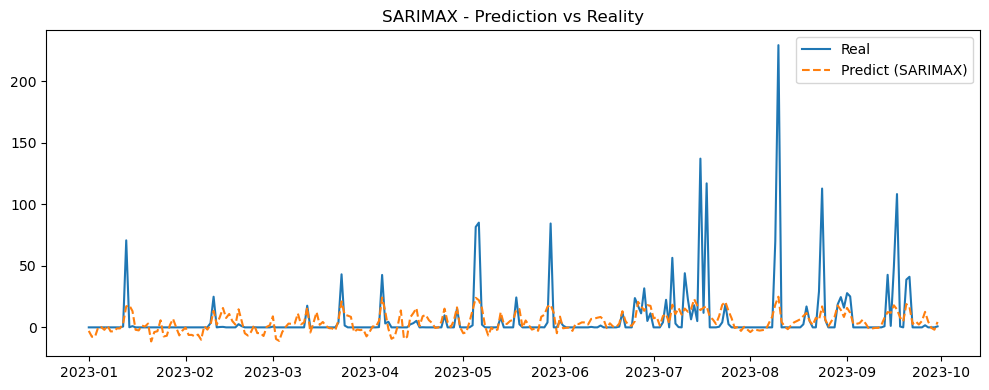

In [150]:
exog = df_sarimax_bis.drop(columns='rainfall')
train_y = df_sarimax_bis['rainfall'][:'2022']
val_y = df_sarimax_bis['rainfall']['2023-01':'2023-09']
train_X = exog[:'2022']
val_X = exog['2023-01':'2023-09']

print("\nSARIMAX")
arimax_model = SARIMAX(train_y, exog=train_X,order=(1, 1, 1))
arimax_result = arimax_model.fit(disp=False)

arimax_pred = arimax_result.predict(start=val_y.index[0], end=val_y.index[-1], exog=val_X)

rmse_arimax = np.sqrt(mean_squared_error(val_y, arimax_pred))
mae_arimax = mean_absolute_error(val_y, arimax_pred)
mse_arimax = mean_squared_error(val_y, arimax_pred)
print(f"SARIMAX - MSE on validation : {mse_arimax:.4f}")
print(f"RMSE on validation : {rmse_arimax:.4f}")
print(f"MAE on validation : {mae_arimax:.4f}")


plt.figure(figsize=(10, 4))
plt.plot(val_y.index, val_y, label='Real')
plt.plot(val_y.index, arimax_pred, label='Predict (SARIMAX)', linestyle='--')
plt.title("SARIMAX - Prediction vs Reality")
plt.legend()
plt.tight_layout()
plt.show()

PROPHET


Prophet


21:19:02 - cmdstanpy - INFO - Chain [1] start processing
21:19:02 - cmdstanpy - INFO - Chain [1] done processing


Index(['ds', 'y'], dtype='object')
Index(['ds', 'trend', 'yhat_lower', 'yhat_upper', 'trend_lower', 'trend_upper',
       'additive_terms', 'additive_terms_lower', 'additive_terms_upper',
       'daily', 'daily_lower', 'daily_upper', 'weekly', 'weekly_lower',
       'weekly_upper', 'yearly', 'yearly_lower', 'yearly_upper',
       'multiplicative_terms', 'multiplicative_terms_lower',
       'multiplicative_terms_upper', 'yhat'],
      dtype='object')


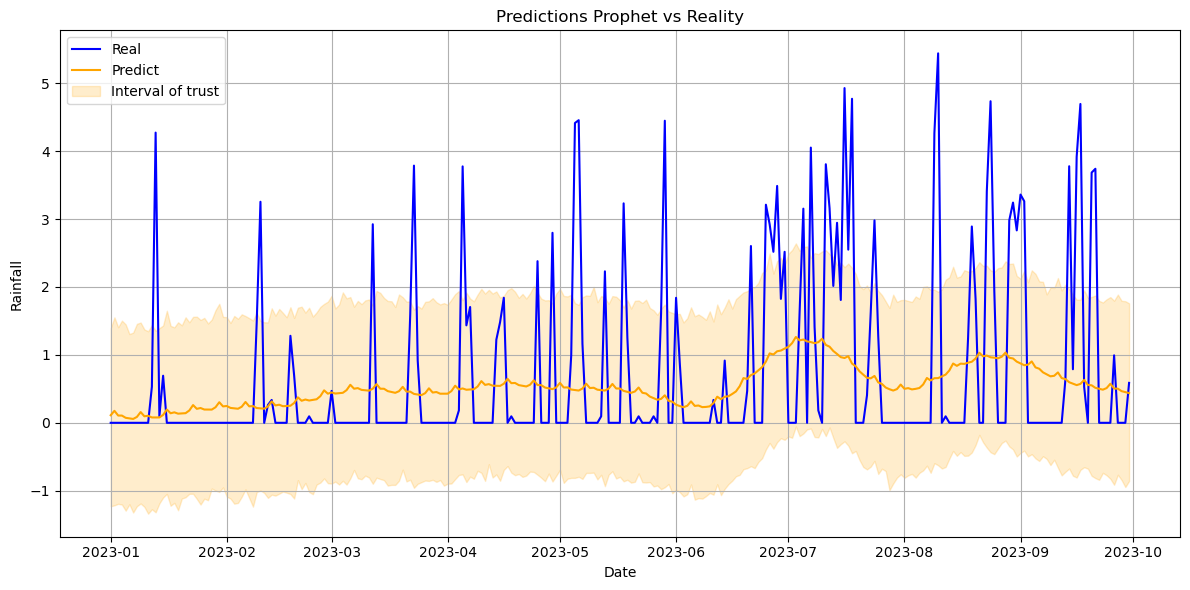

PROPHET - MSE on validation : 595.8136
RMSE on validation : 24.4093
MAE on validation : 7.5652


In [151]:
print("\nProphet")
df_prophet = df_257[['date', 'rainfall']].dropna()
df_prophet = df_prophet.rename(columns={'date': 'ds', 'rainfall': 'y'})

df_prophet['y'] = np.log1p(df_prophet['y'])

train_prophet = df_prophet[df_prophet['ds'] <= '2022-12-31']
val_prophet = df_prophet[(df_prophet['ds'] >= '2023-01-01') & (df_prophet['ds'] <= '2023-09-30')]

model_prophet = Prophet(daily_seasonality=True, yearly_seasonality=True)
model_prophet.fit(train_prophet)

future = val_prophet[['ds']]
forecast = model_prophet.predict(future)
print(val_prophet.columns)
print(forecast.columns)

plt.figure(figsize=(12, 6))
plt.plot(val_prophet['ds'], val_prophet['y'], label='Real', color='blue')
plt.plot(forecast['ds'], forecast['yhat'], label='Predict', color='orange')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='orange', alpha=0.2, label='Interval of trust')
plt.title("Predictions Prophet vs Reality")
plt.xlabel("Date")
plt.ylabel("Rainfall")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

eval_df = forecast[['ds', 'yhat']].merge(val_prophet[['ds', 'y']], on='ds')
eval_df['y_true'] = np.expm1(eval_df['y'])
eval_df['y_pred'] = np.expm1(eval_df['yhat'])

rmse_prophet = np.sqrt(mean_squared_error(eval_df['y_true'], eval_df['y_pred']))
mae_prophet = mean_absolute_error(eval_df['y_true'], eval_df['y_pred'])
mse_prophet = mean_squared_error(eval_df['y_true'], eval_df['y_pred'])
print(f"PROPHET - MSE on validation : {mse_prophet:.4f}")
print(f"RMSE on validation : {rmse_prophet:.4f}")
print(f"MAE on validation : {mae_prophet:.4f}")


Comparison

ARIMA RMSE: 24.72
ARIMA MAE:  7.40
SARIMAX RMSE: 27.01
SARIMAX MAE:  16.18
Prophet RMSE: 24.41
Prophet MAE:  7.57


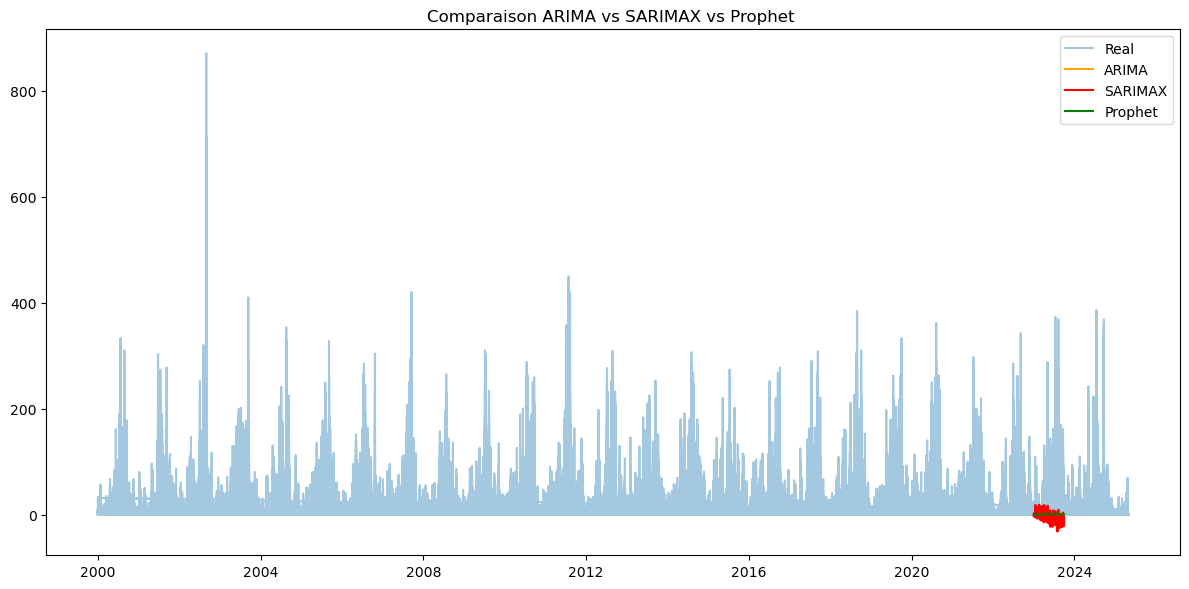

In [152]:
print(f"ARIMA RMSE: {rmse_arima:.2f}")
print(f"ARIMA MAE:  {mae_arima:.2f}")
print(f"SARIMAX RMSE: {rmse_sarimax:.2f}")
print(f"SARIMAX MAE:  {mae_sarimax:.2f}")
print(f"Prophet RMSE: {rmse_prophet:.2f}")
print(f"Prophet MAE:  {mae_prophet:.2f}")

plt.figure(figsize=(12, 6))
plt.plot(df.index, df['rainfall'], label='Real', alpha=0.4)
plt.plot(val.index, arima_pred, label='ARIMA', color='orange')
plt.plot(val.index, sarimax_pred, label='SARIMAX', color='red')
plt.plot(val.index, forecast['yhat'].values, label='Prophet', color='green')
plt.title("Comparison ARIMA vs SARIMAX vs Prophet ")
plt.legend()
plt.tight_layout()
plt.show()